In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import EIANN.utils as ut
import EIANN.plot as pt
pt.update_plot_defaults()

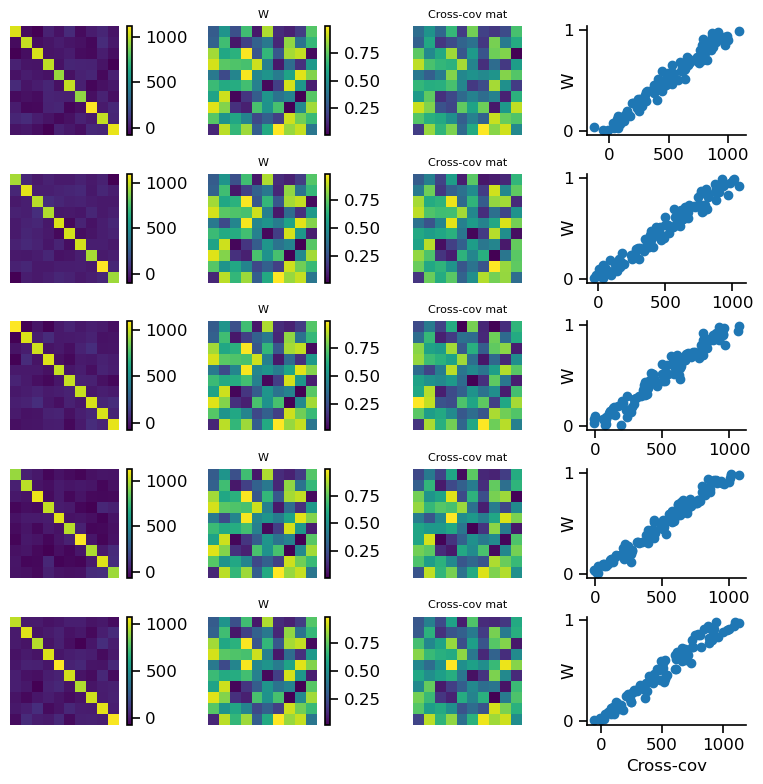

In [4]:
num_samples = 1000
dim = 10

torch.manual_seed(123)
# W = torch.empty((dim, dim)).log_normal_(mean=1, std=2.5)
# W = torch.empty((dim, dim)).normal_(mean=1, std=2)
W = torch.empty((dim, dim)).uniform_(0, 1)
# W = W / W.norm()

n_vals = list(range(1, 11, 2))
fig, axes = plt.subplots(len(n_vals), 4, figsize=(8, 8))
for i,n in enumerate(n_vals):
    # # Data = n-hot encoded
    # X = torch.zeros((num_samples, dim))
    # for s in range(num_samples):
    #     X[s, np.random.choice(dim, n, replace=False)] = 1

    # # Gaussian data
    # X = np.zeros((num_samples, dim))
    # x = np.linspace(-1, 1, dim)
    # gaussian = np.exp(-x**2 / 0.1)
    # for s in range(num_samples):
    #     X[s, :] = np.roll(gaussian, np.random.randint(0, dim))
    # X = torch.tensor(X/np.max(X)).float()
    
    # Random data
    X = torch.randn((num_samples, dim))

    Y = X @ W

    # Covariance matrix between a and b
    m = X.shape[0]  # Number of data points (rows)
    auto_cov_matrix = (X.T @ X) #/ (m - 1)

    # Cross-covariance matrix between a and b
    cross_cov_matrix = (X.T @ Y) #/ (m - 1)

    ax = axes[i,0]
    im = ax.imshow(auto_cov_matrix)
    fig.colorbar(im, ax=ax)
    # ax.set_title(f'Auto-cov mat, {n}-hot', fontsize=8)
    ax.axis('off')

    ax = axes[i, 1]
    im = ax.imshow(W)
    fig.colorbar(im, ax=ax)
    ax.set_title('W', fontsize=8)
    ax.axis('off')

    ax = axes[i, 2]
    im = ax.imshow(cross_cov_matrix)
    # fig.colorbar(im, ax=ax)
    ax.set_title('Cross-cov mat', fontsize=8)
    ax.axis('off')

    ax = axes[i, 3]
    ax.scatter(cross_cov_matrix.flatten(), W.flatten())
    ax.set_ylabel('W', labelpad=-10)
    ax.set_yticks([0, 1])
    if i == len(n_vals) - 1:
        ax.set_xlabel('Cross-cov')

plt.tight_layout(w_pad=0., h_pad=0.5)
plt.show()

intrinsic dimensionality: 18 for 90% variance


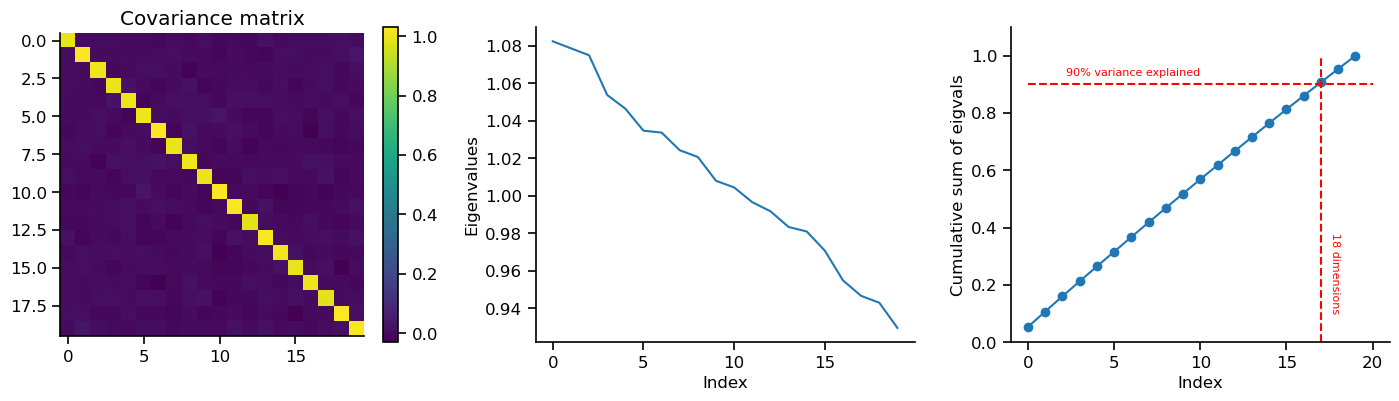

In [5]:
num_samples = 10000
dim = 20

# # Data = n-hot encoded
# X = torch.zeros((num_samples, dim))
# n = 1
# for s in range(num_samples):
#     X[s, np.random.choice(dim, n, replace=False)] = 1

# # X = torch.empty((num_samples, dim)).log_normal_(mean=1, std=2.5)
# # X = torch.empty((num_samples, dim)).normal_(mean=1, std=2)
# X = torch.empty((num_samples, dim)).uniform_(0, 1)

# # # make an example low-rank matrix:
# # X = X @ W.T
# for i in range(1, dim):
#     X[:, i] = X[:, i-1]

# # Gaussian data
# X = np.zeros((num_samples, dim))
# x = np.linspace(-1, 1, dim)
# gaussian = np.exp(-x**2 / 0.1)
# for s in range(num_samples):
#     X[s, :] = np.roll(gaussian, np.random.randint(0, dim))

# Random data
X = torch.randn((num_samples, dim))

# Get sorted eigenvalues
cov = np.cov(X.T)
# cov = np.eye(dim)

eigvals, eigvecs = np.linalg.eig(cov)
eigvals = np.sort(eigvals)[::-1]
eigvals = np.abs(eigvals)

threshold = 90 # Percentage of variance to keep
cumsum = np.cumsum(eigvals) / np.sum(eigvals)
idx = np.where(cumsum >= (threshold/100))[0][0]
print(f"intrinsic dimensionality: {idx+1} for {threshold}% variance")

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
im = ax.imshow(cov)
fig.colorbar(im, ax=ax)
ax.set_title('Covariance matrix')
ax = axes[1]
ax.plot(eigvals)
ax.set_ylabel('Eigenvalues')
ax.set_xlabel('Index')
ax = axes[2]
ax.plot(cumsum, marker='o')
ax.set_ylim(0, 1.1)
ax.hlines(threshold / 100, 0, len(eigvals), 'r', '--')
ax.vlines(idx, 0, 1, 'r', '--')
ax.text(10, threshold/100+0.03, f'{threshold}% variance explained', fontsize=8, ha='right', color='r')
ax.text(idx+0.5, 0.1, f'{idx+1} dimensions', fontsize=8, va='bottom', rotation=-90, color='r')
ax.set_ylabel('Cumulative sum of eigvals')
ax.set_xlabel('Index')
plt.tight_layout()
plt.show()


In [8]:
# bpLike_learnedTD
config_path = "../network_config/mnist/20240830_EIANN_2_hidden_mnist_BP_like_config_2L_learn_TD_HWN_3_complete_optimized.yaml"
saved_network_path = "../data/mnist/20240830_EIANN_2_hidden_mnist_BP_like_config_2L_learn_TD_HWN_3_66049_257_complete.pkl"
network = ut.load_network(saved_network_path)

Loading network from '../data/mnist/20240830_EIANN_2_hidden_mnist_BP_like_config_2L_learn_TD_HWN_3_66049_257_complete.pkl'
Network successfully loaded from '../data/mnist/20240830_EIANN_2_hidden_mnist_BP_like_config_2L_learn_TD_HWN_3_66049_257_complete.pkl'


/Users/ag1880/opt/anaconda3/envs/eiann/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


U,V shapes: (500, 50), (50, 500)
U,S,V shapes: (500, 500), (500,), (500, 500)


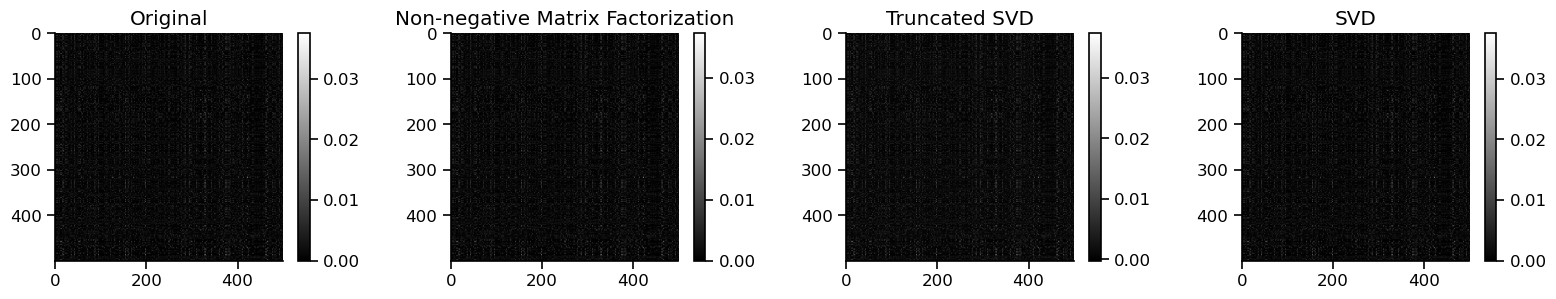

In [9]:
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

w = network.projections['H1E_H2E'].weight.detach()
n_components = 50

# Fit the model and get the two smaller matrices
nmf_model = NMF(n_components=n_components)
U = nmf_model.fit_transform(w)
V = nmf_model.components_ 
w_approx1 = np.dot(U, V)
print(f"U,V shapes: {U.shape}, {V.shape}")

# Non-truncated (regular) SVD   
U, S, V = np.linalg.svd(w)
w_approx3 = np.dot(U, np.dot(np.diag(S), V))
print(f"U,S,V shapes: {U.shape}, {S.shape}, {V.shape}")

# Manual truncated SVD
U_trunc = U[:, :n_components]
V_trunc = V[:n_components, :]
S_trunc = S[:n_components]
w_approx2 = np.dot(U_trunc, np.dot(np.diag(S_trunc), V_trunc))


fig, ax = plt.subplots(1, 4, figsize=(16, 3))
im = ax[0].imshow(w, cmap='gray')
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Original')

im = ax[1].imshow(w_approx1, cmap='gray')
ax[1].set_title('Non-negative Matrix Factorization')
plt.colorbar(im, ax=ax[1])

im = ax[2].imshow(w_approx2, cmap='gray')
ax[2].set_title('Truncated SVD')
plt.colorbar(im, ax=ax[2])

im = ax[3].imshow(w_approx3, cmap='gray')
ax[3].set_title('SVD')
plt.colorbar(im, ax=ax[3])

plt.tight_layout()
plt.show()



In [10]:
# F = network.projections['H1E_H2E'].weight.detach()
# B = network.projections['H2E_H1E'].weight.detach()
# W = F @ B

X = network.H1.E.activity
n_components = 50

# Non-truncated (regular) SVD   
cov_matrix = np.cov(X.T)
U, S, V = np.linalg.svd(cov_matrix)
print(f"U,S,V shapes: {U.shape}, {S.shape}, {V.shape}")

# Manual truncated SVD
U_trunc = U[:, :n_components]
V_trunc = V[:n_components, :]
S_trunc = S[:n_components]

print(f"U,S,V shapes: {U_trunc.shape}, {S_trunc.shape}, {V_trunc.shape}")

U,S,V shapes: (500, 500), (500,), (500, 500)
U,S,V shapes: (500, 50), (50,), (50, 500)


Text(0.5, 1.0, 'Angle between DendI weights and Principal Components')

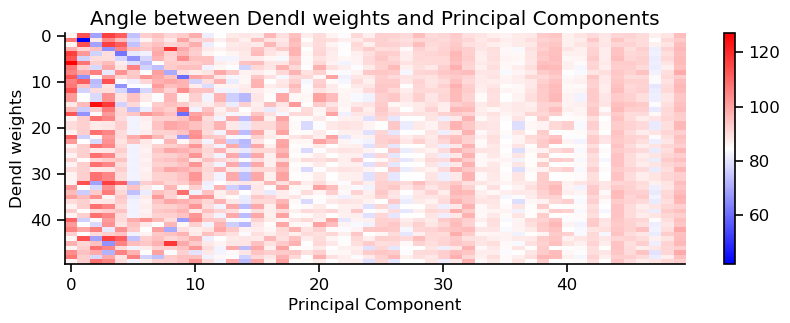

In [11]:
dendF = network.projections['H1DendI_H1E'].weight
combo = torch.tensor(np.dot(np.diag(S_trunc), V_trunc))

angles_all = torch.zeros((len(dendF), U_trunc.shape[1]))
for i,w in enumerate(dendF):
    angles = []
    for pc in U_trunc.T:
        angle = ut.compute_vector_angle(w.flatten(), torch.tensor(pc).flatten().float())
        angles.append(angle)
    angles_all[i] = torch.tensor(angles)

sorted_idx = torch.argmin(angles_all, dim=0)
angles_all = angles_all[sorted_idx]

plt.imshow(angles_all, aspect='auto', interpolation='nearest', cmap='bwr')
plt.colorbar()
plt.xlabel('Principal Component')
plt.ylabel('DendI weights')
plt.title('Angle between DendI weights and Principal Components')

In [12]:
X = network.H1.E.activity

# Perform PCA on a
cov_matrix = np.cov(a.T)
U, S, V = np.linalg.svd(cov_matrix)

# Project a onto the first two principal components
n_components = 2
U_trunc = U[:, :n_components]
a_proj = np.dot(a, U_trunc)

a_proj.shape


NameError: name 'a' is not defined

U,S,V shapes: (500, 500), (500,), (500, 500)


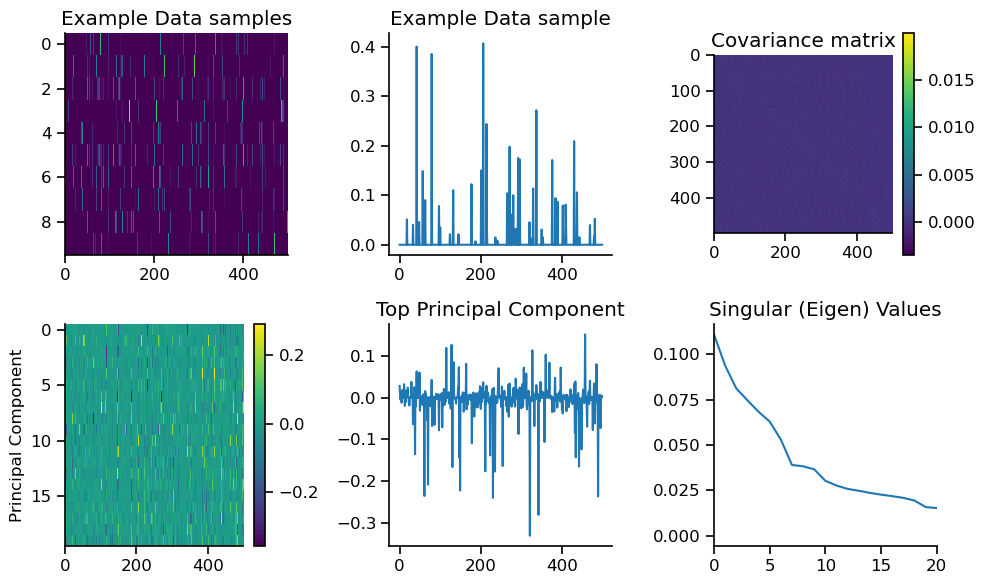

In [13]:
# num_samples = 1000
# dim = 20
# # Data = n-hot encoded
# n = 1
# X = torch.zeros((num_samples, dim))
# for s in range(num_samples):
#     X[s, torch.randint(0, dim, (n,))] = 1

X = network.H1.E.activity.detach()

cov_matrix = np.cov(X.T)
U, S, V = np.linalg.svd(cov_matrix)
print(f"U,S,V shapes: {U.shape}, {S.shape}, {V.shape}")

fig,axes = plt.subplots(2, 3, figsize=(10, 6))

ax = axes[0,0]
ax.imshow(X[:10], aspect='auto', interpolation='nearest')
ax.set_title('Example Data samples')

ax = axes[0,1]
ax.plot(X[0])
ax.set_title('Example Data sample')

ax = axes[0,2]
im = ax.imshow(cov_matrix)
plt.colorbar(im, ax=ax)
ax.set_title('Covariance matrix')

ax = axes[1,0]
im = ax.imshow(U.T[0:20], aspect='auto', interpolation='nearest')
plt.colorbar(im, ax=ax)
ax.set_ylabel('Principal Component')

top_pc = U[:, 0]
ax = axes[1,1]
ax.plot(top_pc)
ax.set_title('Top Principal Component')

ax = axes[1,2]
ax.plot(S)
ax.set_xlim(0, 20)
ax.set_title('Singular (Eigen) Values')

plt.tight_layout()
plt.show()


U,S,V shapes: (20, 20), (20,), (20, 20)


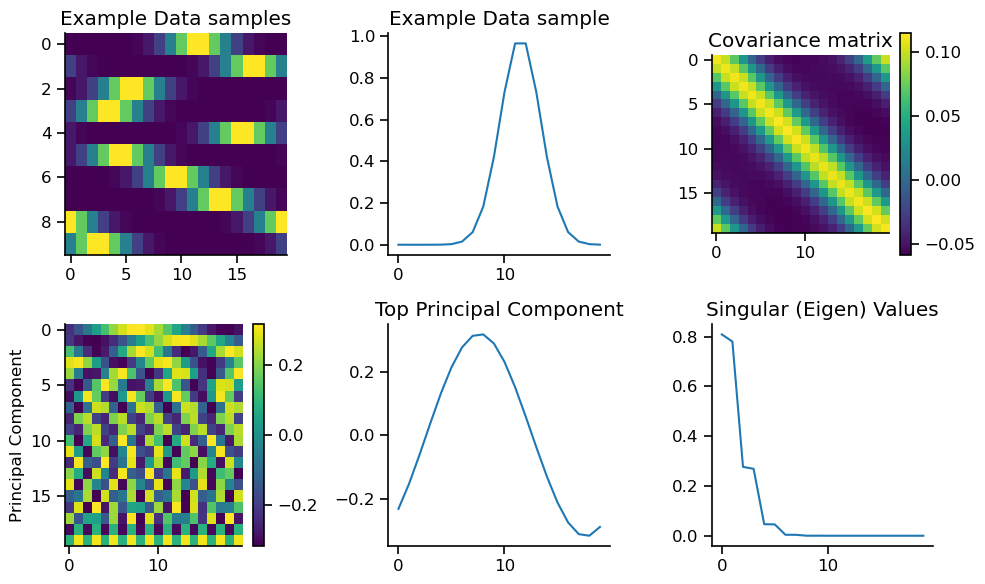

In [14]:
num_samples = 10000
dim = 20

# Gaussian data (make a series of smooth bell curves)
torch.manual_seed(42)
x_ = np.linspace(-5, 5, dim)
mu = 0
std = 1
gaussian = np.exp(-0.5 * ((x_ - mu) / std) ** 2)
X = torch.empty((num_samples, dim))
for j in range(num_samples):
    X[j] = torch.tensor(np.roll(gaussian, torch.randint(0, dim, (1,))))
    
cov_matrix = np.cov(X.T)
U, S, V = np.linalg.svd(cov_matrix)
print(f"U,S,V shapes: {U.shape}, {S.shape}, {V.shape}")

fig,axes = plt.subplots(2, 3, figsize=(10, 6))

ax = axes[0,0]
ax.imshow(X[:10], aspect='auto', interpolation='nearest')
ax.set_title('Example Data samples')

ax = axes[0,1]
ax.plot(X[0])
ax.set_title('Example Data sample')

ax = axes[0,2]
im = ax.imshow(cov_matrix)
plt.colorbar(im, ax=ax)
ax.set_title('Covariance matrix')

ax = axes[1,0]
im = ax.imshow(U.T, aspect='auto', interpolation='nearest')
plt.colorbar(im, ax=ax)
ax.set_ylabel('Principal Component')

top_pc = U[:, 0]
ax = axes[1,1]
ax.plot(top_pc)
ax.set_title('Top Principal Component')

ax = axes[1,2]
ax.plot(S)
ax.set_title('Singular (Eigen) Values')

plt.tight_layout()
plt.show()
